<a href="https://colab.research.google.com/github/jongbinny98/ucsc/blob/master/CSE_144_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 144 Spring 2022 Assignment 3

In this assignment, the goal is to train SVM models to fit the generated data. 

## Data generation

You are provided with a synthetic dataset generated by the make blobs() function from the scikit-learn package. The code to generate and split the dataset is included. When you work on the assignment, please do not modify the data generation code (i.e., the first cell in the notebook). The dataset contains a set of 2-d features xi = (xi1,xi2) with binary labels yi ∈ {−1,1}.

(128, 2) (128,)
(32, 2) (32,)
(40, 2) (40,)


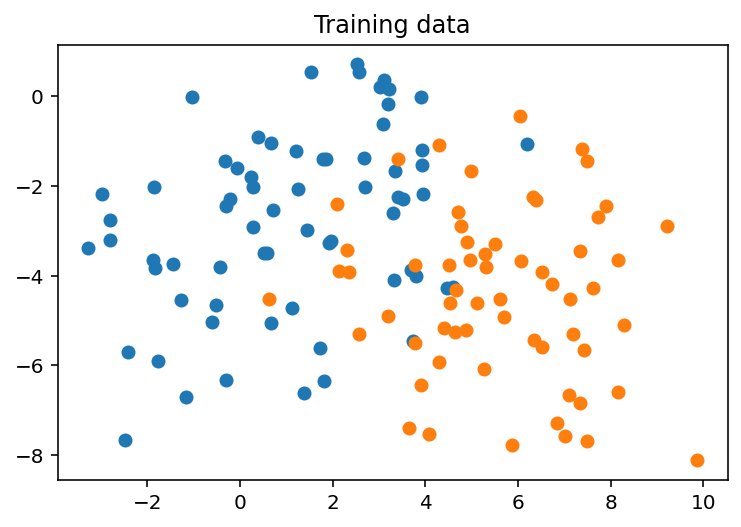

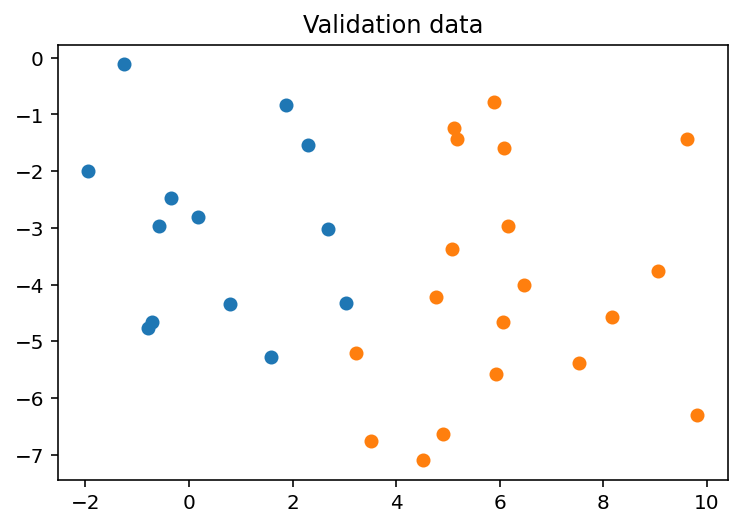

In [1]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format="retina"

# x = 2d features (x1, x2) y = {-1, 1}
def plot_data(x: np.ndarray, y: np.ndarray) -> None:
    # ex. if 1 1 1 -1 -1 class0 = 3, 4 class1 = 0, 1, 2
    # class0_idx = takes index of -1  
    class0_idx = np.where(y == -1)[0]
    # class1_idx = takes index of 1
    class1_idx = np.where(y == 1)[0]

    #first and second columns of x data
    feature0 = x[:, 0]
    feature1 = x[:, 1]

    plt.scatter(feature0[class0_idx], feature1[class0_idx], label="-1")
    plt.scatter(feature0[class1_idx], feature1[class1_idx], label="1")


def modify_label(label):
    return np.array([-1 if i == 0 else 1 for i in label])


x, y = make_blobs(
    n_samples=200,
    n_features=2,
    centers=2,
    cluster_std=2,
    center_box=(-9, 9),
    random_state=1645,
)


x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=288
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=288
)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

y_train, y_val, y_test = map(modify_label, [y_train, y_val, y_test])
plot_data(x_train, y_train)
plt.title("Training data")
plt.show()
plot_data(x_val, y_val)
plt.title("Validation data")
plt.show()

From the data visualization, we can find that the data is not linearly separable. There are two solutions for this: 

1. SVM with soft margin.
2. Solve dual formation of SVM, and use kernel tricks.


For SVM with soft margin, we add 'slack' variable at the beginning, which changes the target problem. This happens to convert the original constrained optimization problem to an unconstrained optimization problem. Therefore, it is convenient for us to do gradient descent directly. Of course, we can also continue solving the dual of this instead.

For SVM with hard margin, typically we just solve the dual problem because it's hard to solve the constrained problem. Suppose we have a dual formation of SVM with either hard or soft margin, we can use a kernel trick to project low-dimension data point to high-dimension space. The first benefit is that we can easily find a hyperplane in high-dimension space to seperate data points. The second benefit is that since the only term related to features is like $x_i^Tx_j$, so if we use $\phi(x_i)$ and $\phi(x_j)$ instead of $x_i$ and $x_j$, then it's sufficient to know $\phi(x_i)^T\phi(x_j)$. This means that we need not know the specific definition of $\phi()$. Just picking a kernel function $\kappa: \mathbb{R}^d\times\mathbb{R}^d\rightarrow \mathbb{R}$ such that there exists $\phi(): \kappa(x_1,x_2)=\phi(x_1)^T\phi(x_2)$ is enough.

In the following, we will implement these two variants of SVM.

## SVM with soft margin (53')

In [2]:
from re import I
class SVMTrainer:
    def __init__(
        self,
        num_examples: int,
        num_features: int = 2,
        learning_rate: float = 1e-2,
        num_epochs: int = 500,
        c: float = 0.07,
        penalty: float = 100
    ) -> None:
        """Initialize a support vector machine trainer."""
        self.c = c
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_examples = num_examples
        self.num_features = num_features

        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_loss = None
        self.test_acc = None

        # Initialize weights and bias. Depenending on your approach, you can either
        # initialize w and b separately or theta as a single vector. 
        # bias = inters, weight =  the direction && normal vector from desicsion boundary
        # weight @ x_train = coeff
        # ========== YOUR CODE STARTS HERE ========== 3'

        self.weight = np.zeros(self.num_features)
        self.bias = 0

        # ========== YOUR CODE ENDS HERE ==========   
    def gradient_descent_step(self, x, y) -> None:
        """
        Perform a single step of gradient update.
        update the parameter

        Args:
            x: A matrix of features.
            y: A vector of labels.
        """
        # basically alpha
        # from my hw 2
        # ========== YOUR CODE STARTS HERE ==========

        dt, db = self.hinge_loss_derivative(x, y)
        self.weight = (self.weight - self.learning_rate * dt)
        self.bias = (self.bias - self.learning_rate * db)

        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss(self, pred, target) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # from the silde 11.11 and piazza post 
        # average of hinge loss
        # ========== YOUR CODE STARTS HERE ========== 5'

        result = 0
        # print("pred.shape: ", pred.shape)
        # print("weight.shape: ", self.weight.shape)
        for i in range(len(pred)):
          Regularization = (1 / (2 * len(pred))) * np.dot(self.weight.T, self.weight)
          #(128,2) (2,0)
          hinge_loss = self.c * max(0, 1 - target[i] * (pred[i] + self.bias))
          result += Regularization + hinge_loss

        return result

        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # self.c = how many errors 
        # from jonathan's session 7,8 and piazza @148
        # ========== YOUR CODE STARTS HERE ==========

        # num_feature = 2
        dt = np.zeros(self.num_features)
        db = 0
        N = self.num_examples

        #for weight
        for j in range(self.num_features):
          for i in range(N):
            pred = 1 - y[i] * (np.dot(x[i], self.weight.T) + self.bias)
            if (pred > 0):
              dt[j] += 1/N * self.weight[j] - self.c * y[i] * x[i][j]
            else:
              dt[j] += 1/N * self.weight[j]

        # for bias
        for i in range(N):
          pred = 1 - y[i] * (np.dot(x[i], self.weight.T) + self.bias)
          if (pred > 0):
            db += -1 * self.c * y[i] 
          else:
            db += 0
        return dt, db

        # ========== YOUR CODE ENDS HERE ==========

    def accuracy(self, pred, target) -> float:
        """
        Calculates the percentage of matched labels given predictions and targets.

        Args:
            pred: Predicted labels (rounded probabilities).
            target: Ground-truth labels.

        Return:
            The accuracy score (a float) given the predicted labels and the true labels.
        """
        # how many labels we predict correct
        # assert pred.shape == target.shape
        # ========== YOUR CODE STARTS HERE ========== 3'

        accuracy = np.sum(pred == target) / len(pred)
        return accuracy 

        # ========== YOUR CODE ENDS HERE ==========

    def predict(self, x) -> int:
        """
        Predict the label of input examples x.

        Args:
            x: Feature vectors.

        Returns:
            A scalar of either -1 or 1.
        """
        # from piazza post @133
        # ========== YOUR CODE STARTS HERE ========== 3'
        # predict yi = result
        result =  np.zeros(len(x))

        for i in range(len(x)):
          pred = x[i] + self.bias
          if (pred < 0):
            result[i] = -1
          else:
            result[i] = 1

        return result

        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10'

        n = self.num_epochs
        
        for epoch in range(n):
          p_train = x_train @ self.weight
          p_val = x_val @ self.weight

          # Do a gradient descent step
          self.gradient_descent_step(x_train, y_train)

          # Calculate train loss
          train_loss = self.hinge_loss(p_train, y_train)

          # Record train loss
          self.train_loss_history.append(train_loss)

          # train prediction 
          p_train = self.predict(p_train)

          # Calculate training accuracy
          self.train_acc_history.append(self.accuracy(p_train, y_train))

          # Calculate validation loss
          val_loss = self.hinge_loss(p_val, y_val)

          # Record validation loss
          self.val_loss_history.append(val_loss)

          # validation prediction
          p_val = self.predict(p_val)

          # calculate validation accuracy
          self.val_acc_history.append(self.accuracy(p_val, y_val))

        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 3'

        p_test = x_test @ self.weight
        # evaluate test loss
        self.test_loss = self.hinge_loss(p_test, y_test)
        # validation prediction
        p_test = self.predict(p_test)
        # calculate test accuracy
        self.test_acc = self.accuracy(p_test, y_test)

        # ========== YOUR CODE ENDS HERE ==========

    def compute_support_vectors(self, x, y) -> np.ndarray:
        """
        Compute support vectors given training data x and y.

        Args:
            x_test: Feature vectors.
            y_test: Ground-truth labels.

        Returns:
            A NumPy array of support vectors.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'

        support_vector = []
        
        for count, (sx, sy) in enumerate(zip(x, y)):
            # all in btw [-1, 1]
            if (sy * (np.dot(sx, self.weight) + self.bias) <= 1 and sy * (np.dot(sx, self.weight) + self.bias) >= -1):
                support_vector.append(sx)

        # print(np.array(support_vector))
        return np.array(support_vector)
       
        # ========== YOUR CODE ENDS HERE ==========

Final train loss: 2.727630504687083
Final validation loss: 0.5239577731245086
Final train acc: 0.8828125
Final validation acc: 1.0


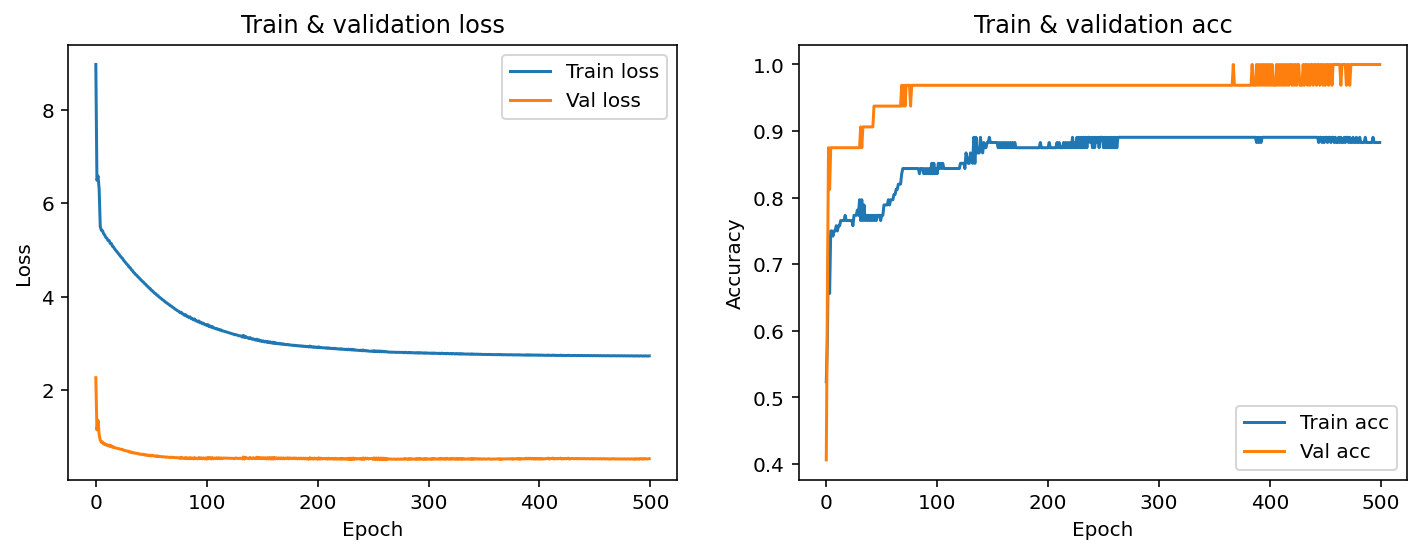

In [3]:
# train SVM with soft margin on our data
# ========== YOUR CODE STARTS HERE ========== 3'

soft_trainer = SVMTrainer(num_examples = len(x_train))
soft_trainer.train(x_train, y_train, x_val, y_val)

# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {soft_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {soft_trainer.val_loss_history[-1]}")
print(f"Final train acc: {soft_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {soft_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(soft_trainer.train_loss_history)), soft_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(soft_trainer.val_loss_history)), soft_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [4]:
def plot_decision_boundary(w, b, x) -> None:
    """
    Plot the decision boundary and margin using w and b. Use this function with 
    plot_data().

    Args:
        w: weights, a vector of length 2.
        b: bias, a scalar.
        x: 2-d feature vectors.
    """
    # from jonathans session 7, 8 and piazza
    # ========== YOUR CODE STARTS HERE ========== 8'

    # use this function with plot_data()
    plot_data(x_train, y_train)
    
    a = -w[0] / w[1]
    xx = np.linspace(min(x[:, 0]), max(x[:, 0]))
    yy = a * xx - (b) / w[1]

    margin = 1 / np.sqrt(np.sum(w ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot doundary
    plt.plot(xx, yy, color = "red", label = "boundary")

    # down margin
    plt.plot(xx, yy_down, "k--", label = "margin")
    
    # up margin
    plt.plot(xx, yy_up, "k--", label = "margin")
    
    # ========== YOUR CODE ENDS HERE ==========

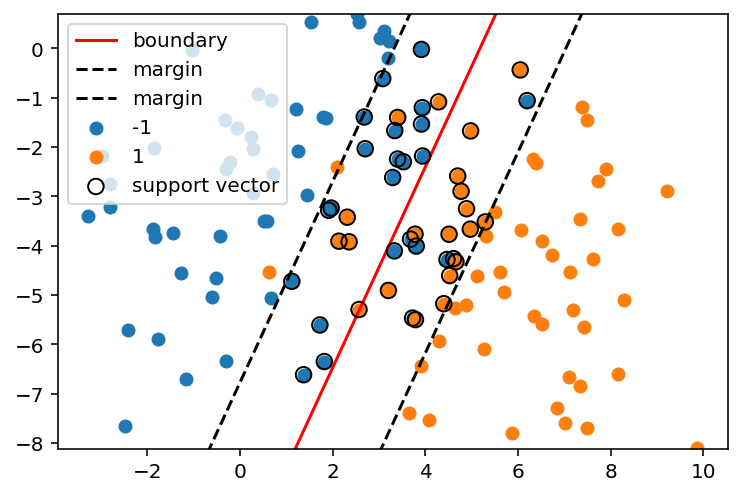

In [5]:
# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'

plot_decision_boundary(soft_trainer.weight, soft_trainer.bias, x_train)
support_vector = soft_trainer.compute_support_vectors(x_train, y_train)

plt.scatter(
    support_vector[:, 0],
    support_vector[:, 1],
    s = 60,
    facecolors = "none",
    zorder = 10,
    edgecolors = "k",
    label = "support vector",
    )

plt.ylim(min(x[:, 1]), max(x[:, 1]))

plt.legend()
plt.show()

# ========== YOUR CODE ENDS HERE ==========

## Dual of hard-margin SVM with kernel trick (41')

In this section, you are required to solve duality formation of SVM with kernel trick. Choose appropriate kernel function to get convergence. 

Hint: different kernels only influent loss function and gradient.

In [6]:
class DualSVMTrainer(SVMTrainer):
    def __init__(self, penalty=1.0, **kwargs):
        super().__init__(**kwargs)
        self.penalty = penalty

        # Initialize model parameters alpha.
        # from piazza @145
        # ========== YOUR CODE STARTS HERE ========== 3'

        self.alpha = np.random.rand(self.num_examples)
        
        # ========== YOUR CODE ENDS HERE ==========
    def gradient_descent_step(self, x, y) -> None:
        """
        Perform a single step of gradient update.
        Args:
            x: A matrix of features.
            y: A vector of labels.
        """
        # lecture silde 15.5
        # ========== YOUR CODE STARTS HERE ==========

        self.alpha = self.alpha - self.learning_rate * self.hinge_loss_derivative(x, y)

        self.alpha = np.clip(self.alpha, 0, self.c) 

         # ========== YOUR CODE ENDS HERE ==========
    def hinge_loss(self, x, y) -> float:
        """
        Calculates the hinge loss given predictions and targets.

        Args:
            pred: Predicted labels.
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        # MIN L(alpha)
        # lecture silde 15.4
        # ========== YOUR CODE STARTS HERE ========== 5'

        result = 0

        for i in range(len(x)):
          first = -np.sum(self.alpha[i])
          for j in range(len(x)):
            second = (0.5) * np.sum(self.alpha[i] * self.alpha[j] * y[i] * y[j] * (x[i].T) * x[j])

        for k in range(len(x)):
          Regularization = self.penalty * np.sum(pow((self.alpha[k] * y[k]), 2))
        
        result = first + second + Regularization

        return result

        # ========== YOUR CODE ENDS HERE ==========

    def hinge_loss_derivative(self, x, y) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # from junbos discussion 0505
        # ========== YOUR CODE STARTS HERE ========== 5'

        dalpha = np.zeros(len(self.alpha))
        N = self.num_examples
        # print("x: ",x.shape)
        # print("y: ",y.shape)
        #for weight
        for i in range(N):
          for j in range(N):
            dalpha = 2 * np.sum(self.alpha[i] * y[i] * y[j] * (x[i].T @ x[j]))
        
        for k in range(N):
          Regularization = 2 * self.penalty * np.sum(self.alpha[k] * y[k])
        
        dalpha = dalpha + Regularization

        return dalpha

        # ========== YOUR CODE ENDS HERE ==========

    def compute_bw(self, x, y):
        """
        Compute weights and bias given model parameter self.alpha, and training data x
        and y.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, or w and b if you choose to
            separate them.
        """
        # lecture sildes 11.16
        # ========== YOUR CODE STARTS HERE ========== 5'

        dt = np.zeros(self.num_features)
        db = 0
        N = self.num_examples

        for i in range(N):
          dt = dt - np.sum(self.alpha[i] * y[i] * x[i])
        
        for j in range(N):
          db = - np.sum(self.alpha[j] * y[j])
        
        return dt, db

        # ========== YOUR CODE ENDS HERE ==========

    def train(self, x_train, y_train, x_val, y_val) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """
        # ========== YOUR CODE STARTS HERE ========== 10'

        n = self.num_epochs
        # self.weight, self.bias = self.compute_bw(x_train, y_train)

        for epoch in range(n):
          self.weight, self.bias = self.compute_bw(x_train, y_train)
          p_train = x_train @ self.weight
          p_val = x_val @ self.weight

          # Do a gradient descent step
          self.gradient_descent_step(x_train, y_train)

          # Calculate train loss
          train_loss = self.hinge_loss(p_train, y_train)

          # Record train loss
          self.train_loss_history.append(train_loss)

          # train prediction 
          p_train = self.predict(p_train)

          # Calculate training accuracy
          self.train_acc_history.append(self.accuracy(p_train, y_train))

          # Calculate validation loss
          val_loss = self.hinge_loss(p_val, y_val)

          # Record validation loss
          self.val_loss_history.append(val_loss)

          # validation prediction
          p_val = self.predict(p_val)

          # calculate validation accuracy
          self.val_acc_history.append(self.accuracy(p_val, y_val))


        # ========== YOUR CODE ENDS HERE ==========

    def evaluate(self, x_test, y_test) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """
        # ========== YOUR CODE STARTS HERE ========== 5'
        # self.weight, self.bias = self.compute_bw(x_test, y_test)
        p_test = x_test @ self.weight
        self.test_loss = self.hinge_loss(p_test, y_test)
        # validation prediction
        p_test = self.predict(p_test)
        self.test_acc = self.accuracy(p_test, y_test)

        # ========== YOUR CODE ENDS HERE ==========
    # def compute_support_vectors(self, x, y) -> np.ndarray:
    #     """
    #     Compute support vectors given training data x and y.

    #     Args:
    #         x_test: Feature vectors.
    #         y_test: Ground-truth labels.

    #     Returns:
    #         A NumPy array of support vectors.
    #     """
    #     # ========== YOUR CODE STARTS HERE ========== 5'

    #     support_vector = []
        
    #     for count, (sx, sy) in enumerate(zip(x, y)):
    #         # all in btw [-1, 1]
    #         if (sy * (np.dot(sx, self.weight) + self.bias) == 1 and sy * (np.dot(sx, self.weight) + self.bias) == -1 ):
    #             support_vector.append(sx)

    #     # print(np.array(support_vector))
    #     return np.array(support_vector)
       
    #     # ========== YOUR CODE ENDS HERE ==========

In [ ]:
# Train SVM dual with kernel trick
# ========== YOUR CODE STARTS HERE ========== 3'

hard_dual_trainer = DualSVMTrainer(num_examples = len(x_train))
hard_dual_trainer.train(x_train, y_train, x_val, y_val)

# ========== YOUR CODE ENDS HERE ==========

print(f"Final train loss: {hard_dual_trainer.train_loss_history[-1]}")
print(f"Final validation loss: {hard_dual_trainer.val_loss_history[-1]}")
print(f"Final train acc: {hard_dual_trainer.train_acc_history[-1]}")
print(f"Final validation acc: {hard_dual_trainer.val_acc_history[-1]}")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_loss_history, label="Train loss")
ax[0].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_loss_history, label="Val loss")
ax[0].set_title("Train & validation loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(np.arange(len(hard_dual_trainer.train_loss_history)), hard_dual_trainer.train_acc_history, label="Train acc")
ax[1].plot(np.arange(len(hard_dual_trainer.val_loss_history)), hard_dual_trainer.val_acc_history, label="Val acc")
ax[1].set_title("Train & validation acc")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.show()

In [ ]:
# Plot the training data along with decision boundary and margin and support vectors
# ========== YOUR CODE STARTS HERE ========== 5'

plot_decision_boundary(hard_dual_trainer.weight, hard_dual_trainer.bias, x_train)
support_vector = hard_dual_trainer.compute_support_vectors(x_train, y_train)

plt.scatter(
    support_vector[:, 0],
    support_vector[:, 1],
    s = 60,
    facecolors = "none",
    zorder = 10,
    edgecolors = "k",
    label = "support vector",
    )

plt.ylim(min(x[:, 1]), max(x[:, 1]))

plt.legend()
plt.show()

# ========== YOUR CODE ENDS HERE ==========

## Evaluation (6')

In [ ]:
# Evaluate your model on the test set
# ========== YOUR CODE STARTS HERE ========== 3'
soft_trainer.evaluate(x_test, y_test)
# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {soft_trainer.test_loss}")
print(f"Test acc: {soft_trainer.test_acc}")

In [ ]:
# ========== YOUR CODE STARTS HERE ========== 3'
print(x_test.shape)
print(y_test.shape)
hard_dual_trainer.evaluate(x_test, y_test)
# ========== YOUR CODE ENDS HERE ==========
print(f"Test loss: {hard_dual_trainer.test_loss}")
print(f"Test acc: {hard_dual_trainer.test_acc}")